In [1]:
import lightkurve as lk
import pandas as pd
import seaborn as sns
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import coordinates
from astroquery.vizier import Vizier
import gaia_tools
from gaia_tools import xmatch
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
from astropy.table import Table
import ezmist
from astroquery.xmatch import XMatch
import astropy.coordinates as coords
import astropy.units as u
from scipy import stats
from matplotlib.pyplot import cm
import mesa_reader as mr
from sympy import Eq, Symbol, solve
import sympy as sp

mpl.rc('font', family='serif', serif='Times New Roman')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import read_mist_models
import glob

from scipy.interpolate import SmoothBivariateSpline
from astropy.stats import median_absolute_deviation

Could not import regions, which is required for some of the functionalities of this module.


In [2]:
import constants as c
print(c.c)

29979245800.0


In [3]:
filein='/Users/melindasoares/Dropbox/Research_LithiumEnrichment/Notebooks/Paper2/ness_GALAH_Gaia_C.dat'
df = pd.read_table(filein,delimiter=' ')
df=df.rename(columns={"tmass_id":"2MASSID","mass":"Galah_mass","teff":"Galah_Teff","logg":"Galah_logg",\
                      "feh": "Galah_Fe_H", "life": "Galah_Li_Fe", "life_err": "Galah_Li_Fe_error",\
                      "source_id": "Gaia_ID","teff_percentile_lower": "Gaia_Teff_lower",\
                     "teff_val": "Gaia_Teff","lum_val": "Gaia_Lum","teff_percentile_upper": "Gaia_Teff_upper",\
                     "lum_percentile_lower": "Gaia_Lum_lower","lum_percentile_upper": "Gaia_Lum_upper"})

print('Initially: Total of',(f"{len(df):,d}"),'stars')
#df.info(verbose=False)
df['Gaia_Lum_err']=(df['Gaia_Lum_upper']-df['Gaia_Lum_lower'])/2
df['Gaia_Teff_err']=(df['Gaia_Teff_upper']-df['Gaia_Teff_lower'])/2
df=df[(df.Gaia_Teff_err<800)]
df.drop(['Gaia_Teff_upper', 'Gaia_Teff_lower','Gaia_Lum_upper','Gaia_Lum_lower'], inplace=True, axis=1)

#df=df[df.Galah_mass>0.90] #limited to stars as massive or more massive than our sun
#df=df[df.Galah_mass<3.0] #limited to stars below our mass investigation limits
#print('Mass Cut: Total of',(f"{len(df):,d}"),'stars')
#these original metallicity bounds are waaaaay too high. :|
df=df[(df.Galah_Fe_H>-0.11)&(df.Galah_Fe_H<=0.11)] #Fe/H bounds to keep objects near solar metallicity
print('Fe/H Cut: Total of',(f"{len(df):,d}"),'stars')
#df.info(verbose=False)
df=df.reset_index()
#df = df.drop(['index'], axis=1)
print('Total stars in the sample',(f"{len(df):,d}"))

Initially: Total of 106,260 stars
Fe/H Cut: Total of 26,183 stars
Total stars in the sample 26,183


In [4]:
#computing A(Li) for all stars
ALisun=1.07 #Asplund
df['NLi_H']=10**(df.Galah_Li_Fe)*10**(df.Galah_Fe_H)*10**(ALisun-12)
df['Galah_ALi']=np.log10(df.NLi_H)+12

#High
df['NLi_H_high']=10**(df.Galah_Li_Fe+df.Galah_Li_Fe_error)*10**(df.Galah_Fe_H)*10**(ALisun-12)
df['Galah_ALi_high']=np.log10(df.NLi_H_high)+12

#Low
df['NLi_H_low']=10**(df.Galah_Li_Fe-df.Galah_Li_Fe_error)*10**(df.Galah_Fe_H)*10**(ALisun-12)
df['Galah_ALi_low']=np.log10(df.NLi_H_low)+12

#some clean up and organization
df.drop(['NLi_H_high','Galah_Li_Fe','NLi_H','Galah_Li_Fe_error','NLi_H_low'], inplace=True, axis=1)
df = df[['2MASSID','Galah_mass','Galah_Teff','Galah_logg','Gaia_ID','Gaia_Teff','Gaia_Teff_err',\
       'Gaia_Lum','Gaia_Lum_err','Galah_Fe_H','Galah_ALi_high','Galah_ALi_low','Galah_ALi']]

df[0:3]

,2MASSID,Galah_mass,Galah_Teff,Galah_logg,Gaia_ID,Gaia_Teff,Gaia_Teff_err,Gaia_Lum,Gaia_Lum_err,Galah_Fe_H,Galah_ALi_high,Galah_ALi_low,Galah_ALi
0,00001566-7601399,1.419446,6270.681657,3.765619,4685151335243015808,6291.0000,108.83325,5.868985,0.147501,0.076258,2.213365,1.976234,2.094799
1,00004408+0449109,1.097024,5157.323461,3.780101,2741942516593385216,5053.9100,304.30250,2.638253,0.083019,0.102626,1.495331,1.426318,1.460825
2,00010086-7250268,1.231218,5047.352601,3.481732,4689673828429744384,4985.5566,138.47750,7.305986,0.259212,-0.079181,1.244375,1.180573,1.212474


In [5]:
#c=Constants()
TLi7=2.5E6
SB=5.6704E-5 #cgs 
#planets plotted
K2137b=0.00482
Trappist1b=0.01151
HATS67b=0.03
K239b=0.057

def const_radius_on_hrd(T,R):
    return 4*np.pi*R**2*SB*T**4

def Params():
    plt.axis([3.8, 3.4, -0.25, 4])
    plt.xlabel(r'$\log \left( T_{\rm eff}\right)$')
    plt.ylabel(r'$\log \left( L / L_\odot \right)$')
    legend = plt.legend(loc='upper left')
    plt.grid()
    
def PlotTracks():
    stringin='/Users/melindasoares/mesa-r21.12.1/mesa_work/1p176Msun_vvcrit0p0/LOGS/history.data'
    h=mr.MesaData(stringin)
    tt1=(np.argmin(h.log_R))
    tt2=len(h.log_R)
    plt.plot(h.log_Teff[tt1:tt2], h.log_L[tt1:tt2],color='darkgrey',alpha=0.7,rasterized=True)
    
def Annotate():
    plt.annotate(str(1.0),(3.795, -0.14),fontsize=20,color='black')

In [6]:
import matplotlib as mpl
plt.rc_fonts = {'figure.figsize': (15, 9.3)}
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['font.size'] = 24
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1
plt.rcParams["legend.framealpha"] = 1.0
plt.rcParams['legend.frameon'] = True
plt.rcParams['axes.titlepad'] = 20 
plt.rc('legend', borderpad=0.2, markerscale=1., fancybox=True)
plt.text.usetex     : True  # use latex for all text handling
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['legend.labelspacing'] = 0.1
##########################################

def PlotMSTO():
    plt.scatter(h.log_Teff[h.center_h1<0.01][0],h.log_L[h.center_h1<0.01][0],\
                s=200,marker='+',color='black')

In [7]:
x=np.log10(df.Gaia_Teff)
y=np.log10(df.Gaia_Lum)
z=df.Galah_ALi

nbins=15
binx= np.linspace(3.5,3.95,num=nbins+1)
biny = np.linspace(-0.8,2.9,num=nbins+1) 

h3, binx1, biny1, bc = stats.binned_statistic_2d(x, y, z, 'count',bins=[binx,biny])
h2, binx1, biny1, bc = stats.binned_statistic_2d(x, y, z, statistic=median_absolute_deviation,bins=[binx,biny])
h1, binx1, biny1, bc = stats.binned_statistic_2d(x, y, z, 'median', [binx,biny])

##########
#flatten h1
h1_tot=h1.flatten()
h2_tot=h2.flatten()
h3_tot=h3.flatten()

#number of bins
x1_tot=[]
y1_tot=[]

for i in range(0,nbins):
    midx=(binx[i+1]-binx[i])/2
    tmp1=binx[i]+midx
    for s in range(0,nbins):
        x1_tot.append(tmp1)
    ii=0
    midy=(biny[i+1]-biny[i])/2
    for t in range(0,nbins):
        y1_tot.append(biny[ii]+midy)
        ii=ii+1

print(x1_tot[0:3])
print(y1_tot[0:3])
print(h1_tot[0:3])

[3.5149999999999997, 3.5149999999999997, 3.5149999999999997]
[-0.6766666666666667, -0.43, -0.18333333333333335]
[nan nan nan]


In [8]:
dbin = pd.DataFrame({'bin_Gaia_Teff':x1_tot, 'bin_Gaia_Lum':y1_tot,'bin_MedianALi':h1_tot,\
                       'bin_MADALi':h2_tot,'bin_count':h3_tot})
print(dbin.bin_count[(dbin.bin_count<5)&(dbin.bin_count>0)].count())
dbin[0:3]

29


,bin_Gaia_Teff,bin_Gaia_Lum,bin_MedianALi,bin_MADALi,bin_count
0,3.515,-0.676667,NaN,NaN,0.0
1,3.515,-0.430000,NaN,NaN,0.0
2,3.515,-0.183333,NaN,NaN,0.0


In [9]:
dbin2=dbin.dropna()
dbin2=dbin2[dbin2.bin_count > 6]
print('total remaining binned entries =',len(dbin2))
dbin2[0:3]

total remaining binned entries = 81


,bin_Gaia_Teff,bin_Gaia_Lum,bin_MedianALi,bin_MADALi,bin_count
37,3.575,1.050000,0.667299,0.083534,11.0
38,3.575,1.296667,0.701073,0.154048,19.0
39,3.575,1.543333,0.548752,0.207188,12.0


In [10]:
f0 = SmoothBivariateSpline(dbin2.bin_Gaia_Teff, dbin2.bin_Gaia_Lum, dbin2.bin_MedianALi)
f1 = SmoothBivariateSpline(dbin2.bin_Gaia_Teff, dbin2.bin_Gaia_Lum, dbin2.bin_MADALi)

#values to determine the enrichment signature
MJ=1.898E30   #mass of jupiter in grams
frac_H=0.75
NLi7=1.7E45
NLi6=1.4E44

In [11]:
def PlotFDU():
#plot the location of the luminosity bump
    ind1=np.argmin(t['conv_env_bot_radius'])
    plt.scatter(t['log_Teff'][ind1],t['log_L'][ind1],\
                s=100,facecolors='none', edgecolors='black',marker='^')

What is the metallicity of our source in question? [Z/H]=-0.21

In [12]:
zsolar=0.02
z=10**(-0.21)*zsolar
z

0.012331900037229645

In [13]:
stringin='/Users/melindasoares/mesa-r21.12.1/mesa_work/1p176Msun_vvcrit0p0/LOGS/history.data'
h=mr.MesaData(stringin)
print(len(h.bulk_names))
print(round(max(h.star_age)/1.0E9,2))
#h.bulk_names

83
5.75


In [14]:
##########################################################################
#We need to ensure that the star has fully contracted from the pMS and has a sizeable convective zone (CZ). 
#t1 is the starting point for our track
#t2 is the final point for our track
#we will start with the maximum t1--t2 interval first
t2=len(h.log_R) #last file computed by MESA 
#find new t1 if the outer convective radius is not at the edge of the star...
t1=np.where(h.center_h1<0.01)[0][0] #MSTO point -- core hydrogren fraction is less than 1%
#ensure that the outer CZ is at the edge of the star and not in the interior
edge=0.99
tmp1=np.where((h.conv_env_top_radius[t1:t2])/10**h.log_R[t1:t2]>edge)[0][0]+t1
##ensure that the inner convective envelope is not at the stellar core, i.e. the CZ is too deep
base=0.001
tmp2=np.where((h.conv_env_bot_radius[t1:t2])/10**h.log_R[t1:t2]>base)[0][0]+t1
#ensure there is sufficient mass in the outer envelope 
#--1.0E-10 cutoff that Jieun uses too
amt=1.0e-10
tmp3=np.where((h.conv_env_top_mass[t1:t2]-h.conv_env_bot_mass[t1:t2])/h.star_mass[t1:t2] > amt)[0][0]+t1
if i>1.6:
    ##ensure the CZ is more than 1 RJ thick
    RJ=0.10049 #radius of Jupiter in Rsun
    depth=1.0*RJ
    tmp4=np.where((h.conv_env_top_radius[t1:t2]-h.conv_env_bot_radius[t1:t2]) > depth)[0][0]+t1
    print(t1,tmp1,tmp2,tmp3,tmp4)
    t1=max(t1,tmp1,tmp2,tmp3,tmp4)
print('t1, t2 =',t1,t2)
print('t1=',t1)
##########################################################################
#We will compute the A(Li) baseline and variance for all points (t1-t2) of our stellar model
#This info will be appended to an array so we can make one table to rule them all.
ALi_base=[]
ALi_var=[]
for k in range(t1,t2):
    ALi_base.append(f0(h.log_Teff[k],h.log_L[k])[0][0])
    ALi_var.append(f1(h.log_Teff[k],h.log_L[k])[0][0])
ALi_base = np.asarray(ALi_base)
ALi_var = np.asarray(ALi_var)
#now that we have an array of the A(Li) baseline and variance, we can compute
#the strength and statistical signifiance of an engulfment signature from a HJ
mass_convective=(10**h.cz_log_xmsun[t1:t2]*c.msun) #mass in C (grams)
NH_star=mass_convective*h.surface_h1[t1:t2]/c.mp #num of stellar H atoms in CZ
NLi_star = 10**(ALi_base-12)*NH_star #num of Li atoms in star
NH_planet=MJ*frac_H/c.mp #num of stellar H atoms in HJ
NLi_planet=NLi7
ALi_engulf=np.log10((NLi_star+NLi_planet)/(NH_star+NH_planet))+12 #A(Li) w/ engulfment
value=80
ALi_engulf3=np.log10((NLi_star+value*NLi_planet)/(NH_star+value*NH_planet))+12 #A(Li) w/ engulfment
##computing the significance of a given signal##
ALi_engulf_statsig=abs(ALi_engulf-ALi_base)/ALi_var 
###########################################################################
##########################################################################
#compute the size of the convective envelope
conv_env=((h.conv_env_top_radius[t1:t2]-h.conv_env_bot_radius[t1:t2]))/10**h.log_R[t1:t2]
conv_env_mass=((h.conv_env_top_mass[t1:t2]-h.conv_env_bot_mass[t1:t2]))/h.star_mass[t1:t2]
##########################################################################
#next we will determine the total amount of mass (in MJ) required to 
#achieve a 5-sigma detection threshold
sigma=5
planet_masses=[]
for hh in range(0,len(ALi_engulf_statsig)):
    x = Symbol('x')
    eq1 = ((x*NLi7+NLi_star[hh])/(x*MJ*frac_H/c.mp+NH_star[hh])-10**(-12+ALi_var[hh]*sigma+ALi_base[hh]))
    a = sp.solve(eq1, x)
    planet_masses.append(a[0])
###########################################################################
##########################################################################
#next we compute the convective mixing time to get a sense of how quickly the Li mixes
##########################################################################
tmix=h.conv_env_turnover_time_g #“Globally-averaged” turnover time (in years)
D=1.0E13 #cm
mixing_time=np.log10(((h.conv_env_top_radius[t1:t2]-h.conv_env_bot_radius[t1:t2])*c.rsun)**2/D*3.17098e-8) #years
##########################################################################
#next we compute the survival time of the A(Li) enrichment signature
### taken from: https://www.aanda.org/articles/aa/pdf/2013/11/aa21793-13.pdf ###
X=10**h.cz_log_h1
T6=(h.conv_env_bot_temp)/1.0E6
eta=84.5*T6**(-1.0/3.0)
rho=h.conv_env_bot_density #rho at the base of the convective envelope 
tb=c.mp/(9.02*10**6*X*rho*eta**2*np.exp(-1.0*eta)) # in years
tb_log=np.log10(tb) #log years
##########################################################################
#next we need to compute the time (in log years) to reach the contour 
#this contour denotes the (Li-burning critical temp)
#this accounts for the fact that not only is the star depleting Li
#the CZ base temperature is also changing with time
##########################################################################
time_to_contour=tmix*0 #creating the proper array sizing
#first find the index where you reach Li burning temperatures
#if (max(h.conv_env_bot_temp[t1:t2])/2.5E6)<1:
#    print('\n star does not reach Li burning conditions')
#else:
#    index=np.where(h.conv_env_bot_temp[t1:t2]>=2.5E6)[0][0]+t1 
    #with np where we add t1 to ensure the indexing lines up
    #at this index, the CZ base exceeds Li-burning
#before reaching the contour
#for g in range(t1,index):
#    time_to_contour[g]=np.log10(h.star_age[index]-h.star_age[g])
##########################################################################
#we can compare this to the time to reach tburn=tmix
#this naively assumes instantaneous changes in the burning efficiency
#when tburn=tmix
#time_to_contour2=tmix*0
#index2=np.where(tb[t1:t2]<=tmix[t1:t2])[0][0]+t1
#for gg in range(t1,index2):
#    time_to_contour2[gg]=np.log10(h.star_age[index2]-h.star_age[gg])        
##########################################################################
#next we will determine the total amount of mass (in MJ) required to 
##########################################################################
#now we create one giant table to rule them all!
t_names=('star_age','log_R','log_Teff','log_L','conv_env_top_radius','conv_env_bot_radius','conv_env',\
         'conv_env_bot_temp','conv_env_mass','mixing_time','ALi_base','ALi_var','ALi_engulf','ALi_engulf_statsig','t_burnLi',\
         't_burnLi_log','tmix','time_to_contour',\
         'destroyed_in_convective_region','destroyed_at_r','destroyed_at_t','surface_h1','NH_star',\
         'Minimum_Mass_Eq1','surface_li7','ALi_engulf3')
t_dtype=(['f8'] * len(t_names))
array=[h.star_age[t1:t2],h.log_R[t1:t2],h.log_Teff[t1:t2],h.log_L[t1:t2],h.conv_env_top_radius[t1:t2],\
       h.conv_env_bot_radius[t1:t2],conv_env,h.conv_env_bot_temp[t1:t2],conv_env_mass,mixing_time,\
       ALi_base,ALi_var,ALi_engulf,ALi_engulf_statsig,tb[t1:t2],tb_log[t1:t2],tmix[t1:t2],time_to_contour[t1:t2],\
       h.destroyed_in_convective_region[t1:t2],h.destroyed_at_r[t1:t2],\
       h.destroyed_at_t[t1:t2],h.surface_h1[t1:t2],NH_star,planet_masses,h.surface_li7[t1:t2],ALi_engulf3]
############################################    
t=Table()
t=Table(array,names=(t_names),dtype=(t_dtype))
df1 = t.to_pandas()
t = Table.from_pandas(df1)
t['Li_survival']=(np.maximum(t['t_burnLi'],t['tmix']))
output='table_vals.dat'
t.write(output,format='ascii',overwrite=True)

52 52 52 52 52
t1, t2 = 52 401
t1= 52


In [15]:
t['surface_li7_N']=t['surface_li7']/(7)
t['Li_lost_delta_ts']=[np.nan]
t['Li_lost_delta_ts_2']=[np.nan]

In [16]:
def find_delta_ts(table,value):
    Li_ratio_added=10**(table['ALi_engulf'][value]-12)-10**(table['ALi_base'][value]-12)
    for k in range(value+1,len(table)):
        Li_lost=(table['surface_li7_N'][value]-table['surface_li7_N'][k])
        if Li_lost>=Li_ratio_added:
            return (table['star_age'][k]-table['star_age'][value]) #years
        if k==(len(table)-1):
            return (table['star_age'][k]-table['star_age'][value]) #years

def find_delta_ts_2(table,value):
    Li_ratio_added=10**(table['ALi_engulf'][value]-12)-10**(table['ALi_base'][value]-12)
    for k in range(value+1,len(table)):
        Li_lost=(10**(table['ALi_base'][value]-12)-10**(table['ALi_base'][k]-12))        
        if Li_lost>=Li_ratio_added:
            return (table['star_age'][k]-table['star_age'][value]) #years
        if k==(len(table)-1):
            return (table['star_age'][k]-table['star_age'][value]) #years

In [17]:
tables=[t]
for tabs in tables:
    for b in range(0,len(tabs)):
        tabs['Li_lost_delta_ts'][b]=find_delta_ts(tabs,b)
        tabs['Li_lost_delta_ts_2'][b]=find_delta_ts_2(tabs,b)

In [18]:
#plot the location of the luminosity bump
def PlotLB():
    for i in range(0,len(t)):
        if (t['log_L'][i]>t['log_L'][i+1]) and (t['log_Teff'][i]<3.7):
            plt.scatter(t['log_Teff'][i], t['log_L'][i],\
                        s=200,color='salmon',marker='d',facecolors='none')
            break

In [19]:
for table in tables:
    dfc = table.to_pandas()
    dfc.Li_lost_delta_ts[dfc.Li_lost_delta_ts>1.0e10]
    print(dfc.Li_lost_delta_ts.min()/1.0e4,dfc.Li_lost_delta_ts.max()/1.0e9)

for table in tables:
    dfc = table.to_pandas()
    dfc.Li_lost_delta_ts_2[dfc.Li_lost_delta_ts_2>1.0e10]
    print(dfc.Li_lost_delta_ts_2.min()/1.0e4,dfc.Li_lost_delta_ts_2.max()/1.0e9)

7.1492218517303465 1.804582073995923
7.1492218517303465 1.77197922706989


In [20]:
for table in tables:
    table['depletion_time']=np.minimum(table['Li_lost_delta_ts_2'],table['Li_lost_delta_ts'])

In [21]:
R=23.59*c.rsun
L=176*c.lsun
Teff=(L/(c.sigmaSB*4*np.pi*(R)**2))**(1.0/4.0)
Teff=np.log10(Teff)

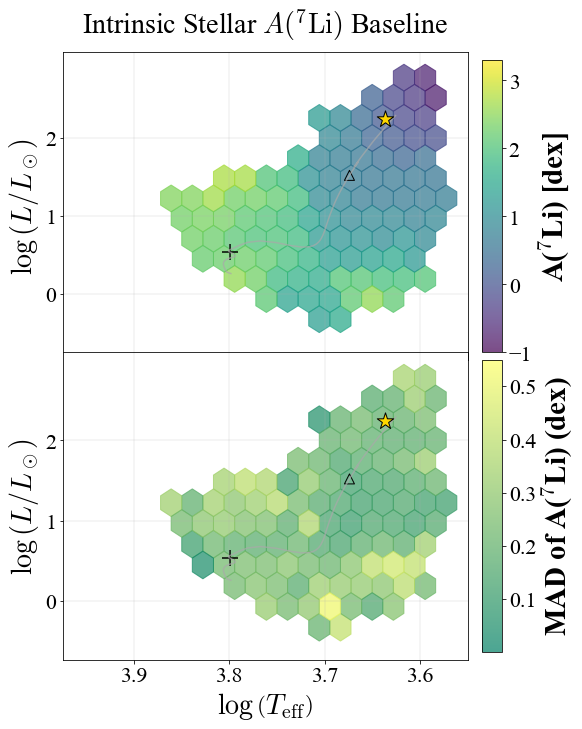

In [22]:
plt.figure(figsize=(8,10))
# top plot
ax1=plt.subplot(2,1,1)  # (nRows, nColumns, axes number to plot)

plt.grid(linewidth=0.25)
plt.hexbin(x=np.log10(df.Gaia_Teff), y=np.log10(df.Gaia_Lum), C=df.Galah_ALi, \
           reduce_C_function=np.nanmedian, cmap="viridis",gridsize=14,mincnt=5,alpha=0.7,\
           vmin=-1,vmax=3.3,rasterized=True)
plt.colorbar(label='A($^7$Li) [dex]',shrink=0.95,pad=.03,aspect=15)
PlotTracks()
PlotFDU()

#Plot the MSTO for each track
plt.scatter(h.log_Teff[h.center_h1<0.01][0],h.log_L[h.center_h1<0.01][0],\
            s=250,marker='+',color='black',rasterized=True)    
plt.scatter(Teff,np.log10(176),marker='*',s=300,color='gold',edgecolors='black',zorder=10)

plt.axis([3.974, 3.55, -0.85, 3.1])
plt.ylabel(r'$\log \left( L / L_\odot \right)$',fontsize=28)
plt.title('Intrinsic Stellar $A(^7\mathrm{Li})$ Baseline',fontsize=28)
plt.yticks([0,1,2])
plt.setp(ax1.get_xticklabels(), visible=False)

# bottom plot
plt.subplot(2,1,2,sharex=ax1)

plt.grid(linewidth=0.25)
plt.hexbin(x=np.log10(df.Gaia_Teff), y=np.log10(df.Gaia_Lum), C=df.Galah_ALi, \
           reduce_C_function=median_absolute_deviation, cmap="summer",gridsize=14,mincnt=5,alpha=0.7,\
           vmin=0.001,vmax=0.55,rasterized=True)
plt.colorbar(label=r'MAD of A($^7$Li) (dex)',shrink=0.95,pad=.03,aspect=15)

PlotTracks()
#Plot the MSTO for each track
plt.scatter(h.log_Teff[h.center_h1<0.01][0],h.log_L[h.center_h1<0.01][0],\
            s=250,marker='+',color='black',rasterized=True)    
plt.scatter(Teff,np.log10(176),marker='*',s=300,color='gold',edgecolors='black',zorder=10)
PlotFDU()
plt.axis([3.974, 3.55, -0.73, 3.1])
plt.yticks([0,1,2])
plt.xlabel(r'$\log \left( T_{\rm eff}\right)$',fontsize=28)
plt.ylabel(r'$\log \left( L / L_\odot \right)$',fontsize=28)
plt.tight_layout(h_pad=-0.6,w_pad=0.1,pad=0.1)

In [23]:
class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

No handles with labels found to put in legend.


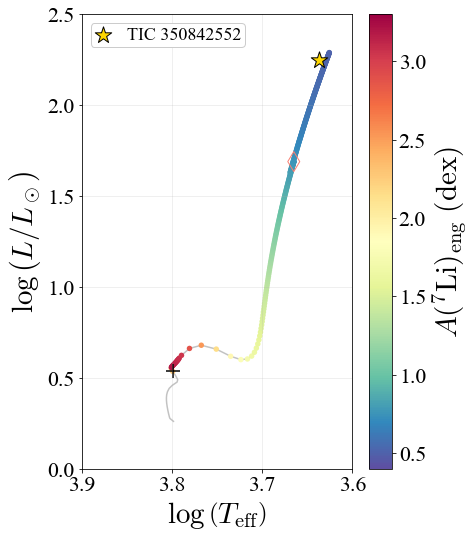

In [24]:
plt.figure(figsize=(7,8))
mycm=plt.cm.Spectral_r
Params()

stringin='/Users/melindasoares/mesa-r21.12.1/mesa_work/1p176Msun_vvcrit0p0/LOGS/history.data'
h=mr.MesaData(stringin)
tt1=(np.argmin(h.log_R))
tt2=len(h.log_R)
plt.plot(h.log_Teff[tt1:tt2], h.log_L[tt1:tt2],color='darkgrey',alpha=0.7,rasterized=True,zorder=0)


vmax=3.3
vmin=0.4

plt.scatter(t['log_Teff'], t['log_L'],c=t['ALi_engulf'],edgecolors='none',\
            s=30,cmap=mycm,rasterized=True,vmin=vmin, vmax=vmax)
plt.colorbar(label=r'$A(^7\mathrm{Li})_{\mathrm{eng}} \ \mathrm{(dex)}$')
plt.scatter(Teff,np.log10(176),marker='*',s=300,color='gold',edgecolors='black',zorder=10,\
            label='TIC 350842552')
#plt.title('$A(^7\mathrm{Li})$ Signature From HJ Engulfment',fontsize=28)
PlotMSTO()
plt.legend(loc='upper left')
PlotLB()
plt.grid(alpha=0.25)
plt.axis([3.9, 3.6, 0, 2.5])
plt.tight_layout(h_pad=1.0)
plt.savefig('/Users/melindasoares/Desktop/Fig3.png',bbox_inches='tight',format='png',facecolor='w')

No handles with labels found to put in legend.


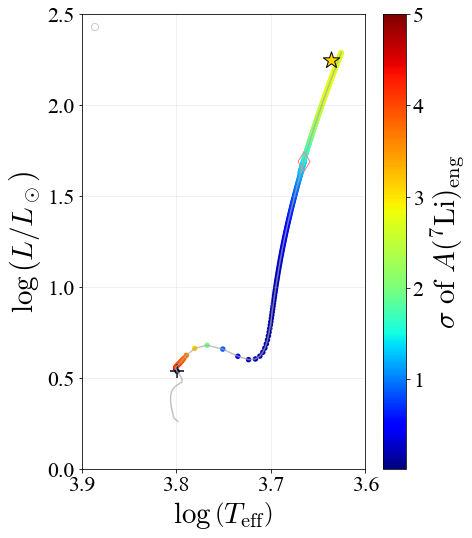

In [25]:
plt.figure(figsize=(7,8))
mycm=plt.cm.jet
Params()
vmin=0.02
vmax=5.0
PlotTracks()
plt.scatter(t['log_Teff'], t['log_L'],c=t['ALi_engulf_statsig'],edgecolors='none',\
            s=30,cmap=mycm,rasterized=True,norm=MidpointNormalize(midpoint=2.0,vmin=vmin, vmax=vmax))
#plt.title('Statistical Significance of Enrichment',fontsize=28)
#index=325
#plt.scatter(t['log_Teff'][index], t['log_L'][index],c=t['ALi_engulf_statsig'][index],edgecolors='black',s=300)

plt.colorbar(label=r'$\sigma \ \mathrm{of} \ A(^7\mathrm{Li})_{\mathrm{eng}}$')
plt.scatter(Teff,np.log10(176),marker='*',s=300,color='gold',edgecolors='black',zorder=10)
PlotMSTO()
PlotLB()
plt.grid(alpha=0.25)
plt.axis([3.9, 3.6, 0, 2.5])
plt.tight_layout(h_pad=1.0)
plt.savefig('/Users/melindasoares/Desktop/Fig4.png',bbox_inches='tight',format='png',facecolor='w')

In [26]:
index=325
print('Baseline A(Li) for this star = ',round(t['ALi_base'][index],2),'dex')

Baseline A(Li) for this star =  -0.01 dex


In [27]:
print('A(Li) due to an engulfed HJ =',round(t['ALi_engulf'][index],2),'dex')

A(Li) due to an engulfed HJ = 0.52 dex


In [28]:
print('Statistical Significance of this engulfment signature = ',round(t['ALi_engulf_statsig'][index],2))

Statistical Significance of this engulfment signature =  2.73


In [29]:
print('A(Li) due to a massive engulfed HJ =',round(t['ALi_engulf3'][index],2),'dex')

A(Li) due to a massive engulfed HJ = 2.24 dex


In [30]:
t[:1]

star_age,log_R,log_Teff,log_L,conv_env_top_radius,conv_env_bot_radius,conv_env,conv_env_bot_temp,conv_env_mass,mixing_time,ALi_base,ALi_var,ALi_engulf,ALi_engulf_statsig,t_burnLi,t_burnLi_log,tmix,time_to_contour,destroyed_in_convective_region,destroyed_at_r,destroyed_at_t,surface_h1,NH_star,Minimum_Mass_Eq1,surface_li7,ALi_engulf3,Li_survival,surface_li7_N,Li_lost_delta_ts,Li_lost_delta_ts_2,depletion_time
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3949169838.4289646,0.1926210876767393,3.79901796430569,0.5360077108472436,1.5580252142249136,1.3456966387472002,0.13626595315822107,649416.3870667098,0.0004011899132959984,-0.16019533636898906,2.292174067633174,0.21715176691767943,2.295519007292061,0.015403695334217461,4011198854744.843,12.603274192616817,0.014442456960210624,0.0,0.0,76174611079.0578,1291490.6878190383,0.7230099987099243,1.0110871605177353e+57,-6676.95332505602,0.0,2.4908322154576297,4011198854744.843,0.0,1804582073.995923,99262751.71483755,99262751.71483755


No handles with labels found to put in legend.


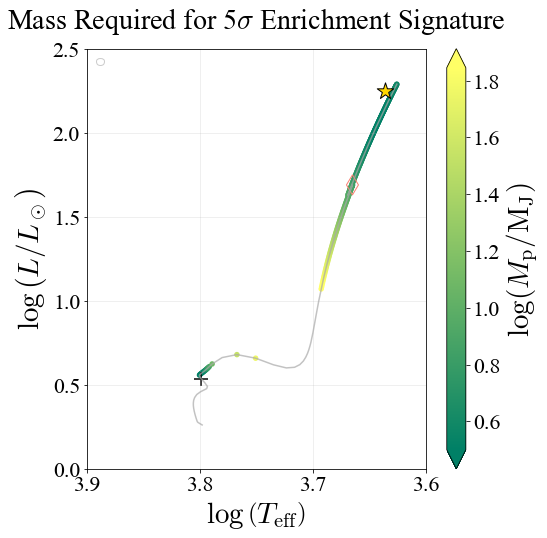

In [31]:
t['Log_Minimum_Mass_Eq1']=np.log10(abs(t['Minimum_Mass_Eq1']))

plt.figure(figsize=(8,8))
mycm=plt.cm.summer
PlotTracks()

vmin=0.5
vmax=np.log10(70)
mass=1.9 

plt.scatter(t['log_Teff'][t['Log_Minimum_Mass_Eq1']<=mass], t['log_L'][t['Log_Minimum_Mass_Eq1']<=mass],\
            c=t['Log_Minimum_Mass_Eq1'][t['Log_Minimum_Mass_Eq1']<=mass],\
            edgecolors='none',s=30,cmap=mycm,rasterized=True,vmin=vmin, vmax=vmax)

plt.title('Mass Required for 5$\sigma$ Enrichment Signature',fontsize=28)
plt.colorbar(label='$\log(M_{\mathrm{p}}/\mathrm{M_{J}})$',extend='both')
plt.scatter(Teff,np.log10(176),marker='*',s=300,color='gold',edgecolors='black',zorder=10)
PlotMSTO()
PlotLB()
Params()
plt.grid(alpha=0.25)
plt.axis([3.9, 3.6, 0, 2.5])
plt.tight_layout(h_pad=1.0)

In [32]:
print('Ingested Mass Required for a 5-sigma Signature = ',round(t['Minimum_Mass_Eq1'][index],2))

Ingested Mass Required for a 5-sigma Signature =  3.49


My verdict:
What is the A(Li) signature of the star in question? If it is well above 

If we believe the 3.3 dex engulfment signature, the presence of enhanced lithium in the star supports the hypothesis that a massive companion was engulfed and chemically mixed into the convective envelop of the star. However, this value is well above the 2.25 dex value that I'd expect for a massive companion (as inferred by Alex Stephan). I can put error bars on that value by performing an MCMC analysis of A(Li) resulting from engulfment across the expected companion mass range and baseline variance range for our system for a more quantitative. Given the proposed meteoritic lithium signature, I think it is possible that the star may also be self-enriched, as a result of the CF process paired with rotationally-driven chemical transport. 

I have asked (Melissa Ness and Sven Buder --- Sven is in charge of the DR4 catalog) for access to the GALAH data for this source and reached out to Sam Quinn see if CHIRON recon spectra are available. If these data become available, I will fold this information in to my analysis.